# EDA of Books 

## Steps 

1. [Importing the libraries](#1-importing-the-libraries)
2. [Importing the dataset](#2-importing-the-dataset)
3. [Data Cleaning](#3-data-cleaning)
4. [Exploratory Data Analysis](#4-exploratory-data-analysis)
5. [Feature Engineering](#5-feature-engineering)
6. [Saving the dataset](#6-saving-the-dataset)




In [1]:
# considerations
# is date of publishing important right now? 
# is price too many missing values to take the average? 
# is the number of pages important? -> possible future feature to include in the scraper 


### 1. Importing the libraries

In [2]:
# set up logger
import logging
import sys
import os
import langdetect
from urllib.request import urlopen
from nltk.tokenize import sent_tokenize
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import re
warnings.filterwarnings('ignore')


### 2. Importing the dataset

In [ ]:
# Setting the environment variables: 
MONGO_URI = os.environ["MONGO_URI"]
MONGO_DB = os.environ["MONGO_DB"]
MONGO_COLLECTION = os.environ["MONGO_COLLECTION"]

In [4]:
pipeline = [
    {
        '$set': {
            'genres': {
                '$objectToArray': '$genres'
            }, 
            'awards': {
                '$objectToArray': '$awards'
            }, 
            'primary_lists': {
                '$objectToArray': '$primary_lists'
            }
        }
    }
]

In [5]:
# Connect to Mongo 
client = pymongo.MongoClient(MONGO_URI)
db = client[MONGO_DB]
collection = db[MONGO_COLLECTION]

ret_raw = collection.aggregate(pipeline)


In [6]:
ret = pd.DataFrame(ret_raw)

In [7]:

df_raw = ret.copy()

### 3. Data Cleaning

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6265 entries, 0 to 6264
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   _id                  6265 non-null   object
 1   book_id              6265 non-null   object
 2   title                6265 non-null   object
 3   author               6265 non-null   object
 4   price                3761 non-null   object
 5   genres               6265 non-null   object
 6   isbn                 4495 non-null   object
 7   language             5178 non-null   object
 8   series               2384 non-null   object
 9   publisher            5267 non-null   object
 10  year_published       5643 non-null   object
 11  description          6265 non-null   object
 12  current_readers      5478 non-null   object
 13  wanted_to_read       6137 non-null   object
 14  num_reviews          6265 non-null   object
 15  num_ratings          6265 non-null   object
 16  rating

In [58]:
df_proc = df_raw.copy()
df_proc.head()

,_id,book_id,title,author,price,genres,isbn,language,series,publisher,...,description,current_readers,wanted_to_read,num_reviews,num_ratings,rating,awards,primary_lists,all_lists_link,date_time_of_scrape
0,641ca91912a3a30fde9c000f,77203.The_Kite_Runner,The Kite Runner,Khaled Hosseini,None,"[{'k': 'Fiction', 'v': 'https://www.goodreads....",None,English,None,Riverhead Books,...,1970s Afghanistan: Twelve-year-old Amir is des...,42.9k,1m,"90,234","2,935,385",4.33,[{'k': 'Borders Original Voices Award for Fict...,[{'k': 'Books That Everyone Should Read At Lea...,/list/book/77203,2023-03-23T20:31:37.567776
1,641ca91e12a3a30fde9c0010,929.Memoirs_of_a_Geisha,Memoirs of a Geisha,Arthur Golden,12.99,"[{'k': 'Fiction', 'v': 'https://www.goodreads....",9781400096893,English,None,Vintage Books USA,...,"A literary sensation and runaway bestseller, t...",12.3k,793k,"34,102","1,922,540",4.14,[],"[{'k': 'Best Books Ever', 'v': '/list/show/1'}...",/list/book/929,2023-03-23T20:31:42.411881
2,641ca92212a3a30fde9c0011,128029.A_Thousand_Splendid_Suns,A Thousand Splendid Suns,Khaled Hosseini,12.99,"[{'k': 'Fiction', 'v': 'https://www.goodreads....",9781594489501,English,None,Riverhead Books,...,Mariam is only fifteen when she is sent to Kab...,32.7k,760k,"69,431","1,417,260",4.42,[{'k': 'British Book Award for Best Read of th...,"[{'k': 'Best Books Ever', 'v': '/list/show/1'}...",/list/book/128029,2023-03-23T20:31:46.875495
3,641ca95d777b6b7756fc3dfe,19063.The_Book_Thief,The Book Thief,Markus Zusak,10.99,"[{'k': 'Historical Fiction', 'v': 'https://www...",None,English,None,Alfred A. Knopf,...,Librarian's note: An alternate cover edition c...,86k,2m,"134,883","2,345,385",4.39,[{'k': 'National Jewish Book Award for Childre...,"[{'k': 'Best Books Ever', 'v': '/list/show/1'}...",/list/book/19063,2023-03-23T20:32:45.197223
4,641ca961777b6b7756fc3dff,4214.Life_of_Pi,Life of Pi,Yann Martel,None,"[{'k': 'Fiction', 'v': 'https://www.goodreads....",9780770430078,English,None,Seal Books,...,Life of Pi is a fantasy adventure novel by Yan...,24.9k,726k,"51,257","1,544,622",3.93,"[{'k': 'Booker Prize (2002)', 'v': 'https://ww...","[{'k': 'Best Books Ever', 'v': '/list/show/1'}...",/list/book/4214,2023-03-23T20:32:49.804773


In [59]:
# lets check the nan values 
df_proc.isna().sum()


_id                       0
book_id                   0
title                     0
author                    0
price                  2504
genres                    0
isbn                   1770
language               1087
series                 3881
publisher               998
year_published          622
description               0
current_readers         787
wanted_to_read          128
num_reviews               0
num_ratings               0
rating                    0
awards                    0
primary_lists             4
all_lists_link            4
date_time_of_scrape       0
dtype: int64

In [60]:
df_proc['series'].unique()

array([None, 'Millennium', 'Frank McCourt', ...,
       'Bianca Goddard Mysteries', 'Florence Nightingale Mystery ',
       'Midwife Mysteries'], dtype=object)

In [61]:
# drop columns that are not needed for now
df_proc.drop(columns=['all_lists_link', 'date_time_of_scrape', 'isbn', '_id'], inplace=True)

# is a series or not change to boolean based on None vs not None (since feature descriptions will be enough to distinguish intrinsic attributes of a book)
df_proc['series'] = df_proc['series'].apply(lambda x: 1 if x != None else 0)
df_proc

,book_id,title,author,price,genres,language,series,publisher,year_published,description,current_readers,wanted_to_read,num_reviews,num_ratings,rating,awards,primary_lists
0,77203.The_Kite_Runner,The Kite Runner,Khaled Hosseini,None,"[{'k': 'Fiction', 'v': 'https://www.goodreads....",English,0,Riverhead Books,"May 1, 2004",1970s Afghanistan: Twelve-year-old Amir is des...,42.9k,1m,"90,234","2,935,385",4.33,[{'k': 'Borders Original Voices Award for Fict...,[{'k': 'Books That Everyone Should Read At Lea...
1,929.Memoirs_of_a_Geisha,Memoirs of a Geisha,Arthur Golden,12.99,"[{'k': 'Fiction', 'v': 'https://www.goodreads....",English,0,Vintage Books USA,"November 22, 2005","A literary sensation and runaway bestseller, t...",12.3k,793k,"34,102","1,922,540",4.14,[],"[{'k': 'Best Books Ever', 'v': '/list/show/1'}..."
2,128029.A_Thousand_Splendid_Suns,A Thousand Splendid Suns,Khaled Hosseini,12.99,"[{'k': 'Fiction', 'v': 'https://www.goodreads....",English,0,Riverhead Books,"June 1, 2007",Mariam is only fifteen when she is sent to Kab...,32.7k,760k,"69,431","1,417,260",4.42,[{'k': 'British Book Award for Best Read of th...,"[{'k': 'Best Books Ever', 'v': '/list/show/1'}..."
3,19063.The_Book_Thief,The Book Thief,Markus Zusak,10.99,"[{'k': 'Historical Fiction', 'v': 'https://www...",English,0,Alfred A. Knopf,"March 14, 2006",Librarian's note: An alternate cover edition c...,86k,2m,"134,883","2,345,385",4.39,[{'k': 'National Jewish Book Award for Childre...,"[{'k': 'Best Books Ever', 'v': '/list/show/1'}..."
4,4214.Life_of_Pi,Life of Pi,Yann Martel,None,"[{'k': 'Fiction', 'v': 'https://www.goodreads....",English,0,Seal Books,"August 29, 2006",Life of Pi is a fantasy adventure novel by Yan...,24.9k,726k,"51,257","1,544,622",3.93,"[{'k': 'Booker Prize (2002)', 'v': 'https://ww...","[{'k': 'Best Books Ever', 'v': '/list/show/1'}..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6260,29901665-death-at-st-vedast,Death at St. Vedast,Mary Lawrence,3.99,"[{'k': 'Mystery', 'v': 'https://www.goodreads....",None,1,Kensington Publishing Corporation,"January 1, 2017","During the tempestuous reign of Henry VIII, Lo...",42,"1,595",59,205,3.90,[],"[{'k': 'Best Medical Thrillers', 'v': '/list/s..."
6261,41959631-a-murderous-malady,A Murderous Malady,Christine Trent,12.99,"[{'k': 'Historical Fiction', 'v': 'https://www...",None,1,Crooked Lane Books,"May 7, 2019",For fans of Charles Todd and Deanna Raybourn c...,16,324,86,232,3.79,[],"[{'k': 'Historical Mystery 2019', 'v': '/list/..."
6262,36445482-no-cure-for-the-dead,No Cure for the Dead,Christine Trent,12.99,"[{'k': 'Mystery', 'v': 'https://www.goodreads....",English,1,Crooked Lane Books,"May 8, 2018","When a young nurse dies on her watch, Florence...",53,621,86,380,3.65,[],"[{'k': 'Historical Fiction 2018', 'v': '/list/..."
6263,15793166-the-midwife-s-tale,The Midwife's Tale,Sam Thomas,5.99,"[{'k': 'Historical Fiction', 'v': 'https://www...",English,1,Minotaur Books,"January 8, 2013",In the tradition of Arianna Franklin and C. J....,63,"7,444",421,"2,855",3.66,[],"[{'k': 'Historical Fiction 2013', 'v': '/list/..."


CLEAN THE TEXT DATA

In [62]:
stop_words = stopwords.words('english')
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [63]:
# lets add bert embeddings for the title and description
df_proc['cleaned_title'] = df_proc['title'].apply(lambda x: x.lower())
df_proc['cleaned_title'] = df_proc['cleaned_title'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df_proc['cleaned_title'] = [remove_stopwords(r.split()) for r in df_proc['cleaned_title']]
df_proc.drop(columns=['title'], inplace=True)

In [64]:
# lets check the average length of the genres list
df_proc['description'].apply(lambda x: len(x)).mean()

840.7409417398244

In [65]:
df_proc['cleaned_description'] = df_proc['description'].apply(lambda x: x.lower())
df_proc['cleaned_description'] = df_proc['cleaned_description'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df_proc['cleaned_description'] = [remove_stopwords(r.split()) for r in df_proc['cleaned_description']]
df_proc.drop(columns=['description'], inplace=True)

In [66]:
#find instance of empy list 
keys = ['genres', 'awards', 'primary_lists']
for key in keys:
     if key == 'primary_lists':
         print(key, len(df_proc[df_proc[key].apply(lambda x: x == None)]))
     else:
         print(key, len(df_proc[df_proc[key].apply(lambda x: len(x) == 0)]))


genres 743
awards 4668
primary_lists 4


In [67]:
# helper functions
# get the key values from a list of dictionaries # account for empy lists

get_key_values_from_list = lambda x: [i['k'] for i in x] if len(x) > 0  else []

get_key_values_from_list_nans = lambda x: [i['k'] for i in x] if x != None else []

In [68]:
def generator_format_list_of_dicts(df, keys):
    """
    Generator function to format the list of dictionaries in the column 'key'
    """
    for key in keys: 
        # apply
        # if value is none then skip
        # if it throws an error then print out the error and skip
        try:
            if key == 'primary_lists':
                df[key] = df[key].apply(get_key_values_from_list_nans)
            else: 
                df[key] = df[key].apply(get_key_values_from_list)
        except Exception as e:
            # print more info about the error
            print('Error in generator_format_list_of_dicts')
            
            print(e)
            continue
    return df


In [69]:
generator_format_list_of_dicts(df_proc, ['genres', 'awards', 'primary_lists'])

,book_id,author,price,genres,language,series,publisher,year_published,current_readers,wanted_to_read,num_reviews,num_ratings,rating,awards,primary_lists,cleaned_title,cleaned_description
0,77203.The_Kite_Runner,Khaled Hosseini,None,"[Fiction, Historical Fiction, Classics, Contem...",English,0,Riverhead Books,"May 1, 2004",42.9k,1m,"90,234","2,935,385",4.33,[Borders Original Voices Award for Fiction (20...,[Books That Everyone Should Read At Least Once...,kite runner,1970s afghanistan twelve year old amir despera...
1,929.Memoirs_of_a_Geisha,Arthur Golden,12.99,"[Fiction, Historical Fiction, Romance, Histori...",English,0,Vintage Books USA,"November 22, 2005",12.3k,793k,"34,102","1,922,540",4.14,[],"[Best Books Ever, Best Historical Fiction, Boo...",memoirs geisha,literary sensation runaway bestseller brillian...
2,128029.A_Thousand_Splendid_Suns,Khaled Hosseini,12.99,"[Fiction, Historical Fiction, Contemporary, Hi...",English,0,Riverhead Books,"June 1, 2007",32.7k,760k,"69,431","1,417,260",4.42,[British Book Award for Best Read of the Year ...,"[Best Books Ever, Books That Everyone Should R...",thousand splendid suns,mariam fifteen sent kabul marry troubled bitte...
3,19063.The_Book_Thief,Markus Zusak,10.99,"[Historical Fiction, Fiction, Young Adult, His...",English,0,Alfred A. Knopf,"March 14, 2006",86k,2m,"134,883","2,345,385",4.39,[National Jewish Book Award for Children’s and...,"[Best Books Ever, Books That Everyone Should R...",book thief,librarian note alternate cover edition found h...
4,4214.Life_of_Pi,Yann Martel,None,"[Fiction, Fantasy, Classics, Adventure, Contem...",English,0,Seal Books,"August 29, 2006",24.9k,726k,"51,257","1,544,622",3.93,"[Booker Prize (2002), Bollinger Everyman Wodeh...","[Best Books Ever, Books That Everyone Should R...",life pi,life pi fantasy adventure novel yann martel pu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6260,29901665-death-at-st-vedast,Mary Lawrence,3.99,"[Mystery, Historical Fiction, Historical Myste...",None,1,Kensington Publishing Corporation,"January 1, 2017",42,"1,595",59,205,3.90,[],"[Best Medical Thrillers, Best Science Thriller...",death st vedast,tempestuous reign henry viii london alchemist ...
6261,41959631-a-murderous-malady,Christine Trent,12.99,"[Historical Fiction, Mystery, Historical Myste...",None,1,Crooked Lane Books,"May 7, 2019",16,324,86,232,3.79,[],"[Historical Mystery 2019, Mystery & Thriller 2...",murderous malady,fans charles todd deanna raybourn comes christ...
6262,36445482-no-cure-for-the-dead,Christine Trent,12.99,"[Mystery, Historical Fiction, Historical Myste...",English,1,Crooked Lane Books,"May 8, 2018",53,621,86,380,3.65,[],"[Historical Fiction 2018, Historical Mystery 2...",cure dead,young nurse dies watch florence nightingale mu...
6263,15793166-the-midwife-s-tale,Sam Thomas,5.99,"[Historical Fiction, Mystery, Fiction, Histori...",English,1,Minotaur Books,"January 8, 2013",63,"7,444",421,"2,855",3.66,[],"[Historical Fiction 2013, most anticipated mys...",midwife tale,tradition arianna franklin c j sansom comes sa...


In [70]:
# lets check the average length of the genres list
df_proc['genres'].apply(lambda x: len(x)).mean()


5.287629688747007

In [71]:
# get all unique genres
all_genres = []
for genres in df_proc['genres']:
    all_genres.extend(genres)

# get unique genres
unique_genres = list(set(all_genres))
print(len(unique_genres), unique_genres)

581 ['Asexual', 'Autistic Spectrum Disorder', 'Political Science', 'Dystopia', 'Modern', 'World History', 'Trains', 'Occult', 'Number', 'Computers', 'Love', 'Fighters', 'Finnish Literature', 'Taoism', 'Economics', 'Nutrition', 'How To', 'Buffy The Vampire Slayer', 'Post Apocalyptic', 'Realistic Fiction', 'Greek Mythology', 'Love Inspired Historical', 'Czech Literature', 'Crime', 'Dragons', 'Education', 'Cross Dressing', 'Medical', 'Numismatics', 'Metaphysics', 'Personal Development', 'Popular Science', 'Ecology', 'India', 'Mystery Thriller', 'Classics', 'Legal Thriller', 'Government', 'Tv', 'The United States Of America', 'Polygamy', 'Picture Books', 'Pulp', 'Womens Fiction', 'Fantasy Romance', 'Faith', 'Green', 'Christian', '18th Century', 'Italy', 'Japan', 'Boarding School', 'Books About Books', 'Robots', 'Terrorism', 'Cities', 'Writing', 'Spirituality', 'Zombies', 'Physics', 'Horses', 'Spain', 'Eugenics', 'Dark Fantasy', 'Reverse Harem', 'Sword and Sorcery', 'Teen', 'Ghost Stories',

In [72]:
# lets clean the genres column
# make everything lowercase 
# remove spaces
# remove punctuation

df_proc['genres'] = df_proc['genres'].apply(lambda x: [i.lower().replace(' ', '').replace('.', '') for i in x])
# if there are no genres then add a 'none' genre
df_proc['genres'] = df_proc['genres'].apply(lambda x: ['none'] if len(x) == 0 else x)
df_proc['genres']

0       [fiction, historicalfiction, classics, contemp...
1       [fiction, historicalfiction, romance, historic...
2       [fiction, historicalfiction, contemporary, his...
3       [historicalfiction, fiction, youngadult, histo...
4       [fiction, fantasy, classics, adventure, contem...
                              ...                        
6260    [mystery, historicalfiction, historicalmystery...
6261    [historicalfiction, mystery, historicalmystery...
6262    [mystery, historicalfiction, historicalmystery...
6263    [historicalfiction, mystery, fiction, historic...
6264    [historicalfiction, mystery, fiction, historic...
Name: genres, Length: 6265, dtype: object

In [73]:
# TODO: add a grouping of genres to decrease unique values of genres based on word embedding similarity

DEAL WITH NUMBERS 

In [74]:
def string_to_float_generator(x): 
    if x == 'None':
        return 0 
    elif type(x) == float:
        return x
    elif 'm' in x:
        return float(x.replace('m', '').replace(',', '')) * 1000000
    elif 'k' in x:
        return float(x.replace('k', '').replace(',', '')) * 1000
    else:
        return 0 

In [75]:
keys = ['current_readers', 'wanted_to_read']

# we have the number of current readers, and the number of people who want to read the book
# we can actually use this to create a popularity metric
df_proc['current_readers'] = df_proc['current_readers'].apply(lambda x: string_to_float_generator(x) if x != None else -1)
df_proc['wanted_to_read'] = df_proc['wanted_to_read'].apply(lambda x: string_to_float_generator(x) if x != None else -1)
# change the string numners to float numbers
df_proc['num_reviews'] = df_proc['num_reviews'].apply(lambda x: float(x.replace(',', '')) if x != None else 0)
df_proc['num_ratings'] = df_proc['num_ratings'].apply(lambda x: float(x.replace(',', '')) if x != None else 0)
df_proc['rating'] = df_proc['rating'].apply(lambda x: float(x) if x != None else 0)
# check the dtypes  of current_readers	wanted_to_read	num_reviews	num_ratings	rating
features = ['current_readers', 'wanted_to_read', 'num_reviews', 'num_ratings', 'rating']

In [76]:
df_proc[features].dtypes

current_readers    float64
wanted_to_read     float64
num_reviews        float64
num_ratings        float64
rating             float64
dtype: object

In [77]:
df_proc['price'] = df_proc['price'].apply(lambda x: float(x.replace('$', '')) if x != None else 0)

In [78]:
# fill price by average price if it is missing 
df_proc['price'] = df_proc['price'].apply(lambda x: df_proc['price'].mean() if x == 0 else x)

In [79]:
# first convert strings to numbers and then replace nan with average based on the genre
df_proc['price'] = df_proc['price'].apply(lambda x: float(x) if x != None else np.nan)

# get the average price for each genre
# df_proc['price'] = df_proc['price'].fillna(df_proc['price'].mean())

# get the average price for each genre
df_proc['price'] = df_proc.groupby('publisher')['price'].transform(lambda x: x.fillna(x.mean()))

In [80]:
# create a popularity metric using the ratings, current readers, and wanted to read, and the number of reviews and standardize it 
# first we create the weights current_readers	wanted_to_read	num_reviews	num_ratings	rating
w_ratings = 0.5
w_current_readers = 0.25
w_wanted_to_read = 0.25
w_reviews = 0.25
w_num_ratings = 0.25



In [81]:
# lets create a popularit metric using the ratings, current readers, and wanted to read, and the number of reviews and standardize it
# Standardized Popularity = (Popularity - μ) / σ

df_proc['popularity'] = (w_ratings * df_proc['rating'] + w_current_readers * df_proc['current_readers'] + w_wanted_to_read * df_proc['wanted_to_read'] + w_reviews * df_proc['num_reviews'] + w_num_ratings * df_proc['num_ratings']) / (w_ratings + w_current_readers + w_wanted_to_read + w_reviews + w_num_ratings)


In [82]:
df_proc['popularity'].describe()

count    6.265000e+03
mean     2.241001e+04
std      8.637548e+04
min     -3.333333e-01
25%      1.627000e+01
50%      2.695167e+02
75%      6.223600e+03
max      1.760151e+06
Name: popularity, dtype: float64

LANGUAGES

In [83]:
# lets see the unique value for language and publisher
languages = df_proc['language'].unique()
publishers = df_proc['publisher'].unique()
# count of books by language

# QA Do we drop the books that are not in English?
#Yes

print('Languages:', languages,'where most books are in english:', df_proc['language'].value_counts(normalize=True)[0] )
print('Publishers:', publishers)

Languages: ['English' None 'German' 'Hindi' 'Spanish; Castilian' 'French'
 'Dutch; Flemish' 'English, Middle (1100-1500)' 'Norwegian' 'Danish'
 'Bokmål, Norwegian; Norwegian Bokmål' 'Swedish' 'Scots' 'Italian'
 'Persian' 'Chinese' 'Multiple languages' 'Undetermined' 'Indonesian'
 'Croatian'] where most books are in english: 0.9733487833140209
Publishers: ['Riverhead Books' 'Vintage Books USA' 'Alfred A. Knopf' ...
 'Hodder and Stoughton ' 'G.P. Putnam’s Sons' 'Red Puddle Print']


In [84]:
df_proc['language'].value_counts()

language
English                                5040
Persian                                  89
Dutch; Flemish                           10
German                                    6
Spanish; Castilian                        5
Italian                                   5
Swedish                                   5
French                                    4
Croatian                                  3
Danish                                    2
Norwegian                                 1
Scots                                     1
English, Middle (1100-1500)               1
Hindi                                     1
Chinese                                   1
Multiple languages                        1
Undetermined                              1
Indonesian                                1
Bokmål, Norwegian; Norwegian Bokmål       1
Name: count, dtype: int64

In [85]:
# check if the book titles are in english if not drop them
# if the book title is asccii then we assume it is in english  and we fill the na with english 
df_proc['language'] = df_proc['language'].apply(lambda x: 'English' if x == None else x)
df_proc['language'].value_counts()

language
English                                6127
Persian                                  89
Dutch; Flemish                           10
German                                    6
Spanish; Castilian                        5
Italian                                   5
Swedish                                   5
French                                    4
Croatian                                  3
Danish                                    2
Norwegian                                 1
Scots                                     1
English, Middle (1100-1500)               1
Hindi                                     1
Chinese                                   1
Multiple languages                        1
Undetermined                              1
Indonesian                                1
Bokmål, Norwegian; Norwegian Bokmål       1
Name: count, dtype: int64

In [86]:
# if language is nan groupby publisher and if language concides with a publisher add english as the nan
df_proc['language'].isna().sum()

0

In [87]:
# drop everything except english
df_proc = df_proc[df_proc['language'] == 'English']
df_proc.drop(columns=['language'], inplace=True)

In [88]:
df_proc.describe()

,price,series,current_readers,wanted_to_read,num_reviews,num_ratings,rating,popularity
count,5144.000000,6127.000000,6127.000000,6.127000e+03,6127.000000,6.127000e+03,6127.000000,6.127000e+03
mean,8.402992,0.384201,1962.758609,4.249658e+04,3705.452587,8.681531e+04,3.906470,2.249799e+04
std,7.606347,0.486446,10167.942967,1.450586e+05,12511.985286,3.798263e+05,0.724017,8.611375e+04
min,0.490000,0.000000,-1.000000,-1.000000e+00,0.000000,0.000000e+00,0.000000,-3.333333e-01
25%,5.544086,0.000000,0.000000,0.000000e+00,11.000000,7.200000e+01,3.780000,1.581167e+01
50%,5.544086,0.000000,0.000000,0.000000e+00,150.000000,1.430000e+03,4.000000,2.695167e+02
75%,9.990000,1.000000,0.000000,1.415000e+04,1387.000000,2.169450e+04,4.210000,6.481982e+03
max,221.490000,1.000000,207000.000000,2.000000e+06,199422.000000,9.208051e+06,5.000000,1.760151e+06


DEAL WITH THE DATES

In [89]:
# df_proc['year_published'].unique
# df_proc['year_published'].dtype

In [90]:
# change dtype to stirng
# df_proc['year_published'] = df_proc['year_published'].apply(lambda x: str(x) if x != None else '')

In [91]:
# # change all year published to age of book
# # change to datetime object
# df_proc['year_published'] = pd.to_datetime(df_proc['year_published'])
# # get the current year
# current_year = pd.to_datetime('today')
# # get the age of the book
# df_proc['age_of_book'] = current_year - df_proc['year_published'].dt.year


In [92]:
# x = df_proc[df_proc['year_published'] == 'May 1, 199']
# # how do I identify special cases like this? 
# x['year_published'].to_string()[-4:-3] == ' ' 
# this led to the realization that there is around 53 books that have a year_published that is not in the correct format
# replace those with nan


# def check_year_published_format(x):
#     counter = 0
#     if x == None: 
#         return np.nan
#     try:
#         return dt.datetime.strptime(x, '%B %d, %Y')
#     except ValueError as e:
#         counter += 1
#         print(e)
#         return np.nan


In [93]:
# convert year_published to datetime object of month day and year
# import datetime as dt 

# df_proc['year_published'] = [x for x in df_proc['year_published'].apply(lambda x: check_year_published_format(x))]

In [94]:
# df_proc['year_published'].isna().sum()

In [95]:
# lets see the 

# df_proc['year_published'].describe()

In [96]:
# df_proc['year_published'].isna().sum()

In [97]:
# df_proc['year_published'].dtype

In [98]:
# change the year published to age of book
# change dtype of year published to str

# df_proc['year_published'] = df_proc['year_published'].apply(lambda x: str(x) if x != None else '')


# df_proc['year_published'].dtype

In [99]:
#convert to dt like object

# df_proc['year_published'] = pd.to_datetime(df_proc['year_published']).dt.year

In [100]:

# df_proc['year_published'].isna().sum()


In [101]:
# # fill with average age of book
# df_proc['year_published'] = df_proc['year_published'].fillna(df_proc['year_published'].mean())
# # convert from float to int
# today = 2023.00
# df_proc['age'] = df_proc['year_published'].apply(lambda x: abs(today - x) if x != None else 0 ) 
# df_proc.drop(columns=['year_published'], inplace=True)
# df_proc.head()

In [102]:
# EXCLUDE AGE OF BOOK FROM THE MODEL SINCE WE AGREED THAT IT IS NOT A GOOD FEATURE
df_proc.drop(columns=['year_published'], inplace=True)

df_proc.head()

,book_id,author,price,genres,series,publisher,current_readers,wanted_to_read,num_reviews,num_ratings,rating,awards,primary_lists,cleaned_title,cleaned_description,popularity
0,77203.The_Kite_Runner,Khaled Hosseini,5.544086,"[fiction, historicalfiction, classics, contemp...",0,Riverhead Books,42900.0,1000000.0,90234.0,2935385.0,4.33,[Borders Original Voices Award for Fiction (20...,[Books That Everyone Should Read At Least Once...,kite runner,1970s afghanistan twelve year old amir despera...,678087.943333
1,929.Memoirs_of_a_Geisha,Arthur Golden,12.990000,"[fiction, historicalfiction, romance, historic...",0,Vintage Books USA,12300.0,793000.0,34102.0,1922540.0,4.14,[],"[Best Books Ever, Best Historical Fiction, Boo...",memoirs geisha,literary sensation runaway bestseller brillian...,460325.046667
2,128029.A_Thousand_Splendid_Suns,Khaled Hosseini,12.990000,"[fiction, historicalfiction, contemporary, his...",0,Riverhead Books,32700.0,760000.0,69431.0,1417260.0,4.42,[British Book Award for Best Read of the Year ...,"[Best Books Ever, Books That Everyone Should R...",thousand splendid suns,mariam fifteen sent kabul marry troubled bitte...,379899.973333
3,19063.The_Book_Thief,Markus Zusak,10.990000,"[historicalfiction, fiction, youngadult, histo...",0,Alfred A. Knopf,86000.0,2000000.0,134883.0,2345385.0,4.39,[National Jewish Book Award for Children’s and...,"[Best Books Ever, Books That Everyone Should R...",book thief,librarian note alternate cover edition found h...,761046.130000
4,4214.Life_of_Pi,Yann Martel,5.544086,"[fiction, fantasy, classics, adventure, contem...",0,Seal Books,24900.0,726000.0,51257.0,1544622.0,3.93,"[Booker Prize (2002), Bollinger Everyman Wodeh...","[Best Books Ever, Books That Everyone Should R...",life pi,life pi fantasy adventure novel yann martel pu...,391131.143333


PUBLISHER & AWARDS

In [103]:

def standardize_publisher_name(publisher):
    # Replace ".com" with an empty string
    publisher = publisher.replace(".com", "")
    
    # Replace 'self-published' and 'self published' with 'self_published'
    publisher = re.sub(r"self[-\s]?published", "self_published", publisher, flags=re.IGNORECASE)

    # Remove all non-alphanumeric characters (except underscores)
    publisher = re.sub(r"[^\w\s]", "", publisher)

    # Convert the publisher name to lowercase
    publisher = publisher.lower()
    
    # Remove leading and trailing whitespaces
    publisher = publisher.strip()
    
    return publisher

def parse_awards(awards_str):
    awards_list = awards_str.strip('][').split(', ')
    return [award.strip() for award in awards_list if award]

In [104]:
publisher_counts = df_proc['publisher'].value_counts()
author_counts = df_proc['author'].value_counts()
publishers_to_replace = publisher_counts[publisher_counts < 10].index
authors_to_replace = author_counts[author_counts < 10].index


In [105]:
df_proc['publisher'] = df_proc['publisher'].replace(publishers_to_replace, 'Others')
df_proc['author'] = df_proc['author'].replace(authors_to_replace, 'Others')


In [106]:
df_proc['genres'].dtypes

dtype('O')

In [261]:
# copy df 

df_eng = df_proc.copy()


In [262]:

# one hot encode the genres
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# change the array of the genres into a string
df_eng['genres'] = df_eng['genres'].apply(lambda x: str(x))

# split the genres into a list
df_eng['genres'] = df_eng['genres'].apply(lambda x: x.split(','))
df_eng['genres'].head()

# one hot encode the genres
df_eng = df_eng.join(pd.DataFrame(mlb.fit_transform(df_eng.pop('genres')),
                            columns=mlb.classes_,
                            index=df_eng.index))



In [263]:
# fix the column titles of the genras by removing [ and ] , ' and spaces

df_eng.columns = df_eng.columns.str.replace("[\[\]']", '', regex=True)


In [264]:
df_eng

,book_id,author,price,series,publisher,current_readers,wanted_to_read,num_reviews,num_ratings,rating,...,urban,urbanfantasy,vampires,war,westerns,witchcraft,writing,youngadult,youngadult,zombies
0,77203.The_Kite_Runner,Others,5.544086,0,Riverhead Books,42900.0,1000000.0,90234.0,2935385.0,4.33,...,0,0,0,0,0,0,0,0,0,0
1,929.Memoirs_of_a_Geisha,Others,12.990000,0,Others,12300.0,793000.0,34102.0,1922540.0,4.14,...,0,0,0,0,0,0,0,0,0,0
2,128029.A_Thousand_Splendid_Suns,Others,12.990000,0,Riverhead Books,32700.0,760000.0,69431.0,1417260.0,4.42,...,0,0,0,0,0,0,0,0,0,0
3,19063.The_Book_Thief,Others,10.990000,0,Alfred A. Knopf,86000.0,2000000.0,134883.0,2345385.0,4.39,...,0,0,0,0,0,0,0,0,0,0
4,4214.Life_of_Pi,Others,5.544086,0,Others,24900.0,726000.0,51257.0,1544622.0,3.93,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6260,29901665-death-at-st-vedast,Others,3.990000,1,Others,0.0,0.0,59.0,205.0,3.90,...,0,0,0,0,0,0,0,0,0,0
6261,41959631-a-murderous-malady,Others,12.990000,1,Others,0.0,0.0,86.0,232.0,3.79,...,0,0,0,0,0,0,0,0,0,0
6262,36445482-no-cure-for-the-dead,Others,12.990000,1,Others,0.0,0.0,86.0,380.0,3.65,...,0,0,0,0,0,0,0,0,0,0
6263,15793166-the-midwife-s-tale,Others,5.990000,1,Minotaur Books,0.0,0.0,421.0,2855.0,3.66,...,0,0,0,0,0,0,0,0,0,0


In [265]:
# awards column number of awards per book
df_eng['awards'] = df_eng['awards'].apply(lambda x: len(x) if x != None else 0)

In [266]:
# get dummies for the author and publisher to make them 0 or 1
df_eng = pd.get_dummies(df_eng, columns=['author', 'publisher'], drop_first=True)

# change true and false to 0 and 1 for all the dummies 



In [267]:
df_eng = df_eng.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [268]:
print(df_eng.columns)
df_eng.head()

Index(['book_id', 'price', 'series', 'current_readers', 'wanted_to_read',
       'num_reviews', 'num_ratings', 'rating', 'awards', 'primary_lists',
       ...
       'publisher_Tor Books', 'publisher_University of Chicago Press',
       'publisher_Viking', 'publisher_Vintage',
       'publisher_Vintage Crime/Black Lizard',
       'publisher_W. W. Norton  Company', 'publisher_W. W. Norton & Company',
       'publisher_Warner Books', 'publisher_William Morrow',
       'publisher_William Morrow Paperbacks'],
      dtype='object', length=1317)


,book_id,price,series,current_readers,wanted_to_read,num_reviews,num_ratings,rating,awards,primary_lists,...,publisher_Tor Books,publisher_University of Chicago Press,publisher_Viking,publisher_Vintage,publisher_Vintage Crime/Black Lizard,publisher_W. W. Norton Company,publisher_W. W. Norton & Company,publisher_Warner Books,publisher_William Morrow,publisher_William Morrow Paperbacks
0,77203.The_Kite_Runner,5.544086,0,42900.0,1000000.0,90234.0,2935385.0,4.33,8,[Books That Everyone Should Read At Least Once...,...,0,0,0,0,0,0,0,0,0,0
1,929.Memoirs_of_a_Geisha,12.990000,0,12300.0,793000.0,34102.0,1922540.0,4.14,0,"[Best Books Ever, Best Historical Fiction, Boo...",...,0,0,0,0,0,0,0,0,0,0
2,128029.A_Thousand_Splendid_Suns,12.990000,0,32700.0,760000.0,69431.0,1417260.0,4.42,5,"[Best Books Ever, Books That Everyone Should R...",...,0,0,0,0,0,0,0,0,0,0
3,19063.The_Book_Thief,10.990000,0,86000.0,2000000.0,134883.0,2345385.0,4.39,20,"[Best Books Ever, Books That Everyone Should R...",...,0,0,0,0,0,0,0,0,0,0
4,4214.Life_of_Pi,5.544086,0,24900.0,726000.0,51257.0,1544622.0,3.93,10,"[Best Books Ever, Books That Everyone Should R...",...,0,0,0,0,0,0,0,0,0,0


In [269]:
df_eng.drop(columns=[ 'primary_lists'], inplace=True)

# save to csv
df_eng.to_csv('df_eng.csv', index=False)

In [234]:
# Normalize the numerical values in the dataframe 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#get a list of numerical columns
numerical = df_eng.select_dtypes(include=['int64', 'float64']).columns
# scale the numerical columns
df_eng[numerical] = scaler.fit_transform(df_eng[numerical])

df_eng.head()

,book_id,price,series,current_readers,wanted_to_read,num_reviews,num_ratings,rating,awards,cleaned_title,...,publisher_Tor Books,publisher_University of Chicago Press,publisher_Viking,publisher_Vintage,publisher_Vintage Crime/Black Lizard,publisher_W. W. Norton Company,publisher_W. W. Norton & Company,publisher_Warner Books,publisher_William Morrow,publisher_William Morrow Paperbacks
0,77203.The_Kite_Runner,-0.375894,-0.789878,4.026437,6.601343,6.916217,7.500276,0.585021,3.297176,kite runner,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169
1,929.Memoirs_of_a_Geisha,0.603109,-0.789878,1.016733,5.174217,2.429593,4.833458,0.322575,-0.360748,memoirs geisha,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169
2,128029.A_Thousand_Splendid_Suns,0.603109,-0.789878,3.023202,4.946704,5.253436,3.503057,0.709338,1.925455,thousand splendid suns,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169
3,19063.The_Book_Thief,0.340145,-0.789878,8.265595,13.495672,10.485007,5.946807,0.667899,8.784062,book thief,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169
4,4214.Life_of_Pi,-0.375894,-0.789878,2.256023,4.712297,3.800790,3.838401,0.032502,4.211657,life pi,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169


In [235]:
# do embeddings for title and description


df_emb = df_eng.copy()



In [236]:
# drop duplicate columns 
df_emb = df_emb.loc[:,~df_emb.columns.duplicated()]
df_emb.head()

,book_id,price,series,current_readers,wanted_to_read,num_reviews,num_ratings,rating,awards,cleaned_title,...,publisher_Tor Books,publisher_University of Chicago Press,publisher_Viking,publisher_Vintage,publisher_Vintage Crime/Black Lizard,publisher_W. W. Norton Company,publisher_W. W. Norton & Company,publisher_Warner Books,publisher_William Morrow,publisher_William Morrow Paperbacks
0,77203.The_Kite_Runner,-0.375894,-0.789878,4.026437,6.601343,6.916217,7.500276,0.585021,3.297176,kite runner,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169
1,929.Memoirs_of_a_Geisha,0.603109,-0.789878,1.016733,5.174217,2.429593,4.833458,0.322575,-0.360748,memoirs geisha,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169
2,128029.A_Thousand_Splendid_Suns,0.603109,-0.789878,3.023202,4.946704,5.253436,3.503057,0.709338,1.925455,thousand splendid suns,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169
3,19063.The_Book_Thief,0.340145,-0.789878,8.265595,13.495672,10.485007,5.946807,0.667899,8.784062,book thief,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169
4,4214.Life_of_Pi,-0.375894,-0.789878,2.256023,4.712297,3.800790,3.838401,0.032502,4.211657,life pi,...,-0.074701,-0.042409,-0.055773,-0.104352,-0.042409,-0.046111,-0.040433,-0.042409,-0.06271,-0.051169


EXTRA STUFF FOR FUTURE IMPLEMENTATIONS

In [220]:
#embedding
import re
word_embeddings = {}
f = open('/Users/vera/Downloads/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

len(word_embeddings)

400001

In [237]:
def vectorization_gen(x):
    if len(x) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in x.split()])/(len(x.split())+0.001)
        yield v
    else:
        v = np.zeros((100,))
        yield v
    
    

In [238]:
df_emb['emb_description'] = df_emb['cleaned_description'].apply(lambda x: next(vectorization_gen(x)))


In [239]:
df_emb['emb_title'] = df_emb['cleaned_title'].apply(lambda x: next(vectorization_gen(x)))

In [240]:
# drop cleaned description and title
df_emb.drop(columns=['cleaned_description', 'cleaned_title'], inplace=True)


In [241]:
import pandas as pd
from sklearn.decomposition import PCA



# Let's say the description_embeddings is a list of lists (or 2D array-like structure)
description_embeddings = df_emb['emb_description'].tolist()

# Apply PCA to reduce dimensionality of the embeddings
pca = PCA(n_components=100) 
reduced_embeddings = pca.fit_transform(description_embeddings)

# Convert the reduced embeddings back into a DataFrame
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=[f'pca_{i+1}' for i in range(reduced_embeddings.shape[1])])

# Merge the reduced embeddings DataFrame back with your original dataset
data_with_reduced_embeddings = pd.concat([df_emb.reset_index(drop=True), reduced_embeddings_df.reset_index(drop=True)], axis=1)

df_emb = data_with_reduced_embeddings.copy()

In [242]:

# title_embeddings = df_emb['emb_title'].tolist()

# # Apply PCA to reduce dimensionality of the embeddings
# pca = PCA(n_components=50)
# reduced_embeddings = pca.fit_transform(title_embeddings)

# # Convert the reduced embeddings back into a DataFrame
# reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=[f'pcatitle_{i+1}' for i in range(reduced_embeddings.shape[1])])

# # Merge the reduced embeddings DataFrame back with your original dataset
# data_with_reduced_embeddings = pd.concat([data_with_reduced_embeddings.reset_index(drop=True), reduced_embeddings_df.reset_index(drop=True)], axis=1)

# data_with_reduced_embeddings.head()

In [243]:
df_fin = df_emb.copy()
df_fin.dtypes.value_counts()

float64    987
object       3
Name: count, dtype: int64

In [244]:
# show the dtypes which are objects
df_fin.select_dtypes(include=['object']).columns

Index(['book_id', 'emb_description', 'emb_title'], dtype='object')

In [245]:
# drop the columns which are objects
df_fin = df_fin.drop(columns=['book_id', 'emb_description', 'emb_title'], inplace=False)



In [246]:
for x in df_fin.columns:
    print(x)

price
series
current_readers
wanted_to_read
num_reviews
num_ratings
rating
awards
popularity
 12thcentury
 15thcentury
 16thcentury
 17thcentury
 18thcentury
 19thcentury
 1stgrade
 20thcentury
 21stcentury
 2ndgrade
 40k
 abuse
 academia
 academic
 action
 activism
 adoption
 adult
 adultfiction
 adventure
 africa
 africanamerican
 africanamericanromance
 africanliterature
 alchemy
 algebra
 algorithms
 aliens
 alternatehistory
 amazon
 american
 americana
 americancivilwar
 americanfiction
 americanhistory
 americanrevolution
 americanrevolutionarywar
 ancient
 ancienthistory
 angels
 animalfiction
 animals
 anthologies
 anthropology
 antiracist
 antisemitism
 apocalyptic
 archaeology
 architecture
 arithmetic
 art
 arthistory
 arthurian
 artificialintelligence
 asexual
 asia
 asianliterature
 astrology
 astronomy
 atheism
 audiobook
 australia
 autisticspectrumdisorder
 autobiography
 aviation
 bandedessinée
 bannedbooks
 baseball
 basketball
 batman
 bdsm
 beautyandthebeast
 biogra

In [249]:
df_fin.head()


float64    987
Name: count, dtype: int64

# XGBOOST

In [251]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score




# split data into X and y
y = df_fin['rating']
X = df_fin.drop(columns=['rating'], axis=1)

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [256]:
# make predictions for test data
y_pred = model.predict(X_test)



RMSE: 0.415680


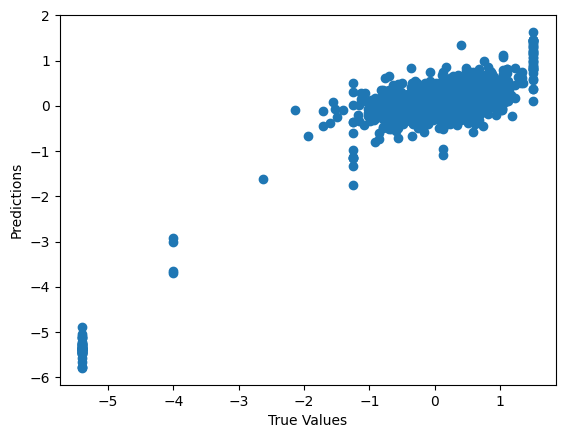

In [257]:
# evaluate predictions
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rms))

# plot
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()


In [259]:
# best metrics for regression
r_squared = model.score(X_test, y_test)
print("R-squared: ", r_squared)

# mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)




R-squared:  0.8314984893490415
MAE:  0.31441298532192685


In [260]:
import pickle
pickle.dump(model, open("xgb_model.pkl", "wb"))